# Set Up

In [1]:
import torch
torch.manual_seed(42)  # for reproducibility (same results across runs)
# Choose where to run: MPS (Apple Silicon), CUDA (NVIDIA GPU), or CPU.
if torch.backends.mps.is_available():
  DEVICE = torch.device("mps")  # Apple Silicon Metal Performance Shaders
elif torch.cuda.is_available():
  DEVICE = torch.device("cuda")  # GPU
else:
  DEVICE = torch.device("cpu")   # CPU


In [2]:
print("Using device:", DEVICE)

Using device: mps


In [3]:
from sklearn import datasets as sk_datasets
X, y = sk_datasets.load_diabetes(return_X_y=True, as_frame=True)
X = X.iloc[-200:]
y = y.iloc[-200:]
X_train = torch.tensor(X.values, dtype=torch.float32).to(DEVICE)
y_train = torch.tensor(y.values, dtype=torch.float32).to("cpu")
print(X_train.device)
X_train = X_train.to("cpu")
print(X_train.device)

mps:0
cpu


In [4]:
X_with_intercept = torch.cat([torch.ones(X_train.shape[0], 1, dtype=X_train.dtype), X_train], dim=1)
solution = torch.linalg.lstsq(X_with_intercept, y_train.unsqueeze(1)) # lstsq expects RHS shape (n, 1) for single output
coefficients = solution.solution.flatten()   # length 11: intercept, then 10 feature coefs
print("Intercept:", coefficients[0].item())
print("Two coefficients (e.g. bmi, bp):", coefficients[3].item(), coefficients[4].item())

Intercept: 152.05950927734375
Two coefficients (e.g. bmi, bp): 546.1898803710938 408.4148864746094


In [5]:
from torch import nn
#contains neural network building blocks: layers, loss functions, and the base class
import torch.optim as optim
#contains optimizers (SGD,Adam..) that implement gradient-based parameters update

#Here, I am going to define a model that PyTorch should. treat as a trainable model.
#nn.Module is a PyTorch's base class for all models
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, bias=True): 
        #input_dim = numbers of features/regressors, bias= True for the intercept
        super().__init__()  # calls constructor of parent class nn.Module
        #it registers parameters so PyTorch knows what to differentiate and optimize
        self.linear = nn.Linear(input_dim, 1, bias=bias) # one linear layer: input_dim -> 1 output
        #creates a weight matrix and a bias scalar


    def forward(self, x): #defines how predictions are computed
        return self.linear(x)
# With a class we don't have to manually track the parameters, compute the gradients and update the coefficients.
model = LinearRegressionModel(input_dim=X_train.shape[1])
# Creates a linear regression model with the correct dimensionality.
model = model.to(DEVICE) # Model and data must be on the same device
X_train = X_train.to(DEVICE)
y_train = y_train.to(DEVICE)

criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01)
#we don't solve it analytically but use an optimization algorithm to find the parameters that minimize the loss function.

# Training loop (enough epochs to approach OLS solution)
epochs = 50000
for epoch in range(epochs): # one epoch = one pass over the entire training set
    # FORWARD PASS: compute predictions and loss.
    outputs = model(X_train) # calls LinearRegressionModel.forward(x)
    loss = criterion(outputs, y_train.unsqueeze(1))  # target shape (n, 1) to match outputs

    # BACKWARD PASS: compute gradients, then update parameters.
    optimizer.zero_grad()  # clear gradients before each backward (otw. they accumulate)
    loss.backward()        # fill gradients for all parameters with requires_grad=True
    optimizer.step()       # update parameters using those gradients

    if (epoch + 1) % 5000 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
        #prints training progress every 5 000 epochs

# Display the model's coefficients
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f'{name}: {param.detach().cpu().numpy()}') # move to CPU for .numpy() if needed

#These are the estimated OLS coefficients, obtained via gradient descent instead of matrix algebra.


Epoch [5000/50000], Loss: 16467.6094
Epoch [10000/50000], Loss: 8020.4341
Epoch [15000/50000], Loss: 4216.0083
Epoch [20000/50000], Loss: 3449.6143
Epoch [25000/50000], Loss: 3194.2488
Epoch [30000/50000], Loss: 3021.3784
Epoch [35000/50000], Loss: 2902.3015
Epoch [40000/50000], Loss: 2827.1616
Epoch [45000/50000], Loss: 2780.8799
Epoch [50000/50000], Loss: 2756.5327
linear.weight: [[  50.88487  -217.2237    471.00705   427.02527   -65.9594     -7.058796
  -270.20355    44.71536   451.69965   -20.076242]]
linear.bias: [151.8997]


100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s] 


Label: horse
Image size: torch.Size([3, 32, 32])


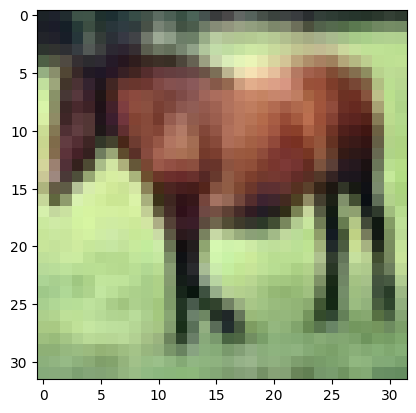

In [6]:
from torchvision import datasets
from torchvision.transforms import ToTensor #conerts images to PyTorch tensors
import matplotlib.pyplot as plt #to display images

training_data = datasets.CIFAR10( #  CIFAR-10 is 60k small images in 10 classes.
    root="data",           # directory where data is stored 
    train=True,            # True = training split, False = test split
    download=True,
    transform=ToTensor()   # convert PIL image to tensor, scale pixels to [0, 1]
)

#load the test data
test_data = datasets.CIFAR10(root="data", train=False, download=True, transform=ToTensor())

image, label = training_data[7] # Indexing a Dataset returns one sample.
print(f"Label: {training_data.classes[label]}")
print(f"Image size: {image.shape}")   # Image shape is (Channels, Height, Width), e.g. (3, 32, 32) for RGB 32×32. add batch dim later for (N, C, H, W).
plt.imshow(image.permute(1, 2, 0))    # permute to (H, W, C) for matplotlib
plt.show()

Here, we are preparing data for training a machine-learning model so that it is:
- Efficient (load data fast)
- Stochastic (Shuffle the data)
- Reproducible (same results when we re run)

We take a dataset, split it into mini-batches, load the mini batches in parallel, while controlling the randomness so that the experiments are repeatable.

Mini-batches to add noise for Gradient descent.
DataLoader automates this batching.

A worker is a seperate process whose job is to load the data.
Same seed, same random behavior.
The generator decides which sample go into which batch.

Batch size: torch.Size([64, 3, 32, 32])


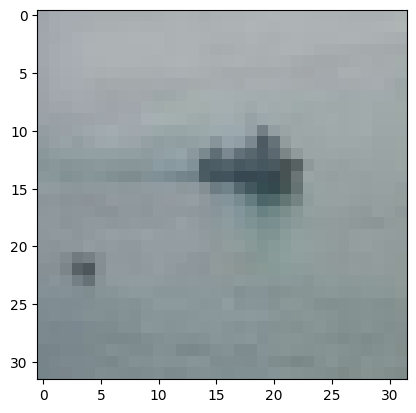

In [8]:
from torch.utils.data import DataLoader
#imports DataLoader: PyTorch utility that splits a dataset into mini-batches, optionnally shuffles data, loads data in parallel using multiple CPU
import numpy as np
import random

def seed_worker(worker_id): # Reproducibility: seed workers and generator so shuffle is deterministic.
  # Each worker has a different seed based on the initial seed, so they don't produce the same random numbers.
  worker_seed = torch.initial_seed() % 2**32 #torch.initial_seed() gives the initial seed for the current worker, and we take modulo 2^32 to fit it into a 32-bit integer for numpy and random.
  #ensure each worker gets a deterministic seed.
  np.random.seed(worker_seed)
  #set NumPy's random seed inside that worker
  random.seed(worker_seed) #set Python's random seed inside that worker
g_seed = torch.Generator() #create a generator for reproducibility of shuffling across workers
g_seed.manual_seed(torch.initial_seed() % 2**32) #seed the generator with a deterministic seed based on the initial seed

train_dataloader = DataLoader(training_data, # Wrap training data in a DataLoader that yields batches (mini-batches) for training.
  batch_size=64, # each iteration gives 64 samples.
  shuffle=True, # random order each epoch.
  num_workers=0, # parallel loading, here I set it to 0 because it was not working with two on jupyter notebooks.
  worker_init_fn=seed_worker, generator=g_seed)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True, num_workers=2,
  worker_init_fn=seed_worker, generator=g_seed)

batch_images, batch_labels = next(iter(train_dataloader)) # next batch: shapes (batch_size, C, H, W) and (batch_size,).
print('Batch size:', batch_images.shape)
plt.imshow(batch_images[0].permute(1, 2, 0))
plt.show()

#train_dataloader: is an object that knows where the dataset is, how big batches should be, whether to shuffle, and how to load data in parallel.
#iter() builds an iterator for an epoch
#next() fetches the first batch


We are fitting a linear regression model using mini-batch stochastic gradient descent.
we are treatinng the model as a paraletrized function and iteratively updating parameters using gradients.

Instead of using all observations at once, we use small chunks.

In [9]:
from torch.utils.data import TensorDataset, DataLoader
# Wrap tensors in a Dataset, then DataLoader

train_dataset = TensorDataset(X_train, y_train)
#combines X_train and y_train into a single dataset object.

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # 32 samples per batch, random order each epoch.
#each step processes 32 observations
#data is randomly permuted each epoch

model_mb = LinearRegressionModel(input_dim=X_train.shape[1]).to(DEVICE)
criterion = nn.MSELoss()
optimizer_mb = optim.Adam(model_mb.parameters(), lr=0.01)

model_mb.train() # Training mode so dropout/BatchNorm (if any) behave correctly during training.

n_epochs = 500
for epoch in range(n_epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader: # Batch = a subset of the training data. One forward/backward/step per batch.
        batch_x = batch_x.to(DEVICE) # size (batch_size, n_features)
        batch_y = batch_y.to(DEVICE) # size (batch_size,)

        #model and data must live on the same device.

        # Forward: predictions and loss for this batch only.
        pred = model_mb(batch_x)
        loss = criterion(pred, batch_y.unsqueeze(1))  # target shape (batch_size, 1) to match pred

        # Backward: compute gradients, then optimizer step (update parameters).
        optimizer_mb.zero_grad()  # clear gradients from previous batch (they accumulate by default)
        loss.backward()           # fill gradients for parameters with requires_grad=True
        optimizer_mb.step()       # update parameters using those gradients

        epoch_loss += loss.item() 

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch + 1}/{n_epochs}, mean loss: {epoch_loss / len(train_loader):.4f}")

# Evaluation / inference 
model_mb.eval() # toggle disables dropout/BatchNorm training behavior
with torch.no_grad(): # Avoids storing gradients (saves memory).
    preds = model_mb(X_train[:10].to(DEVICE))   # example: predict on first 10 samples
print("Sample predictions (first 3):", preds[:3].detach().cpu().numpy().flatten())

Epoch 100/500, mean loss: 28557.7874
Epoch 200/500, mean loss: 25439.1797
Epoch 300/500, mean loss: 23249.3605
Epoch 400/500, mean loss: 22399.3983
Epoch 500/500, mean loss: 21097.8613
Sample predictions (first 3): [22.177624 29.933098 28.115124]
